# Test Factor Models VaR and ES
This notebook demonstrates how to use:
- A single-factor model Value-at-Risk (VaR) and Expected Shortfall (ES)
- A Fama-French 3-factor model for VaR and ES

It uses historical return data and factor models to estimate portfolio risk.

In [1]:
import data_download as dd
import factor_models as fm
import pandas as pd
import numpy as np
import plots

##  Download data and form a portfolio

In [2]:
# Define tickers and shares
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "JPM",
    "UNH", "KO", "PEP", "BMW.DE", "NESN.SW",
    "NOVN.SW", "ASML.AS"
]

# Assign number of shares per asset
shares = pd.Series(10, index=tickers)

# Download adjusted prices
prices = dd.get_raw_prices(tickers, start="2022-01-01")

# Compute daily value of each position
position_values = prices * shares

# Compute total portfolio value over time
portfolio_value_series = position_values.sum(axis=1)

# Compute asset weights (based on latest available prices)
latest_prices = prices.iloc[-1]
portfolio_value = (shares * latest_prices).sum()
weights = (shares * latest_prices) / portfolio_value

# Compute daily asset returns and portfolio returns
returns = prices.pct_change().dropna()
portfolio_returns = returns @ weights

# Combine historical values into one DataFrame
portfolio_df = position_values.copy()
portfolio_df["PORTFOLIO"] = portfolio_value_series

# Display results
portfolio_df.head()


,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH,PORTFOLIO
Date,,,,,,,,,,,,,
2022-01-03,1786.456299,6772.234497,736.722107,1443.016205,1469.958038,537.828369,3256.347351,1150.985565,649.150009,300.682220,1572.986603,4789.945984,24466.313248
2022-01-04,1763.783417,6575.349731,759.792480,1437.124176,1525.683899,546.807289,3200.510559,1153.479538,650.281296,292.386780,1575.260010,4681.421204,24161.880379
2022-01-05,1716.866913,6474.976807,776.329041,1371.194305,1497.791290,551.342087,3077.649536,1122.304459,655.372391,275.556335,1580.625153,4669.881897,23769.890213
2022-01-06,1688.206787,6355.302124,776.167679,1370.920563,1513.703613,548.439865,3053.330688,1119.810410,659.412918,281.286221,1580.988617,4478.772888,23426.342373
2022-01-07,1689.875183,6417.070312,771.166306,1363.650513,1528.701782,547.170143,3054.887390,1108.587341,660.463486,271.992531,1582.989197,4373.395996,23369.950180


In [3]:
print(weights)

AAPL       0.079383
ASML.AS    0.256695
BMW.DE     0.030769
GOOGL      0.059643
JPM        0.099179
KO         0.025815
MSFT       0.169263
NESN.SW    0.031849
NOVN.SW    0.033401
NVDA       0.048576
PEP        0.048062
UNH        0.117365
dtype: float64


In [4]:
portfolio_value

26747.699432373047

## Single-Factor VaR and ES

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [5]:
# download SP prices
sp = dd.get_raw_prices(["^GSPC"], start="2022-01-01")

# compute benchmark returns
benchmark = sp["^GSPC"].pct_change().dropna()

# align benchmark with asset returns
benchmark = benchmark.reindex(returns.index).ffill()

In [6]:
results_df, portfolio_volatility = fm.single_factor_var(
    returns=returns,
    benchmark=benchmark,
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)


In [7]:
results_df.head()   

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary
Date,,,,,
2022-01-04,-0.010264,-0.000630,0.028707,False,767.856276
2022-01-05,-0.019714,-0.019393,0.028707,False,767.856276
2022-01-06,-0.010154,-0.000964,0.028707,False,767.856276
2022-01-07,-0.001504,-0.004050,0.028707,False,767.856276
2022-01-10,-0.013391,-0.001441,0.028707,False,767.856276



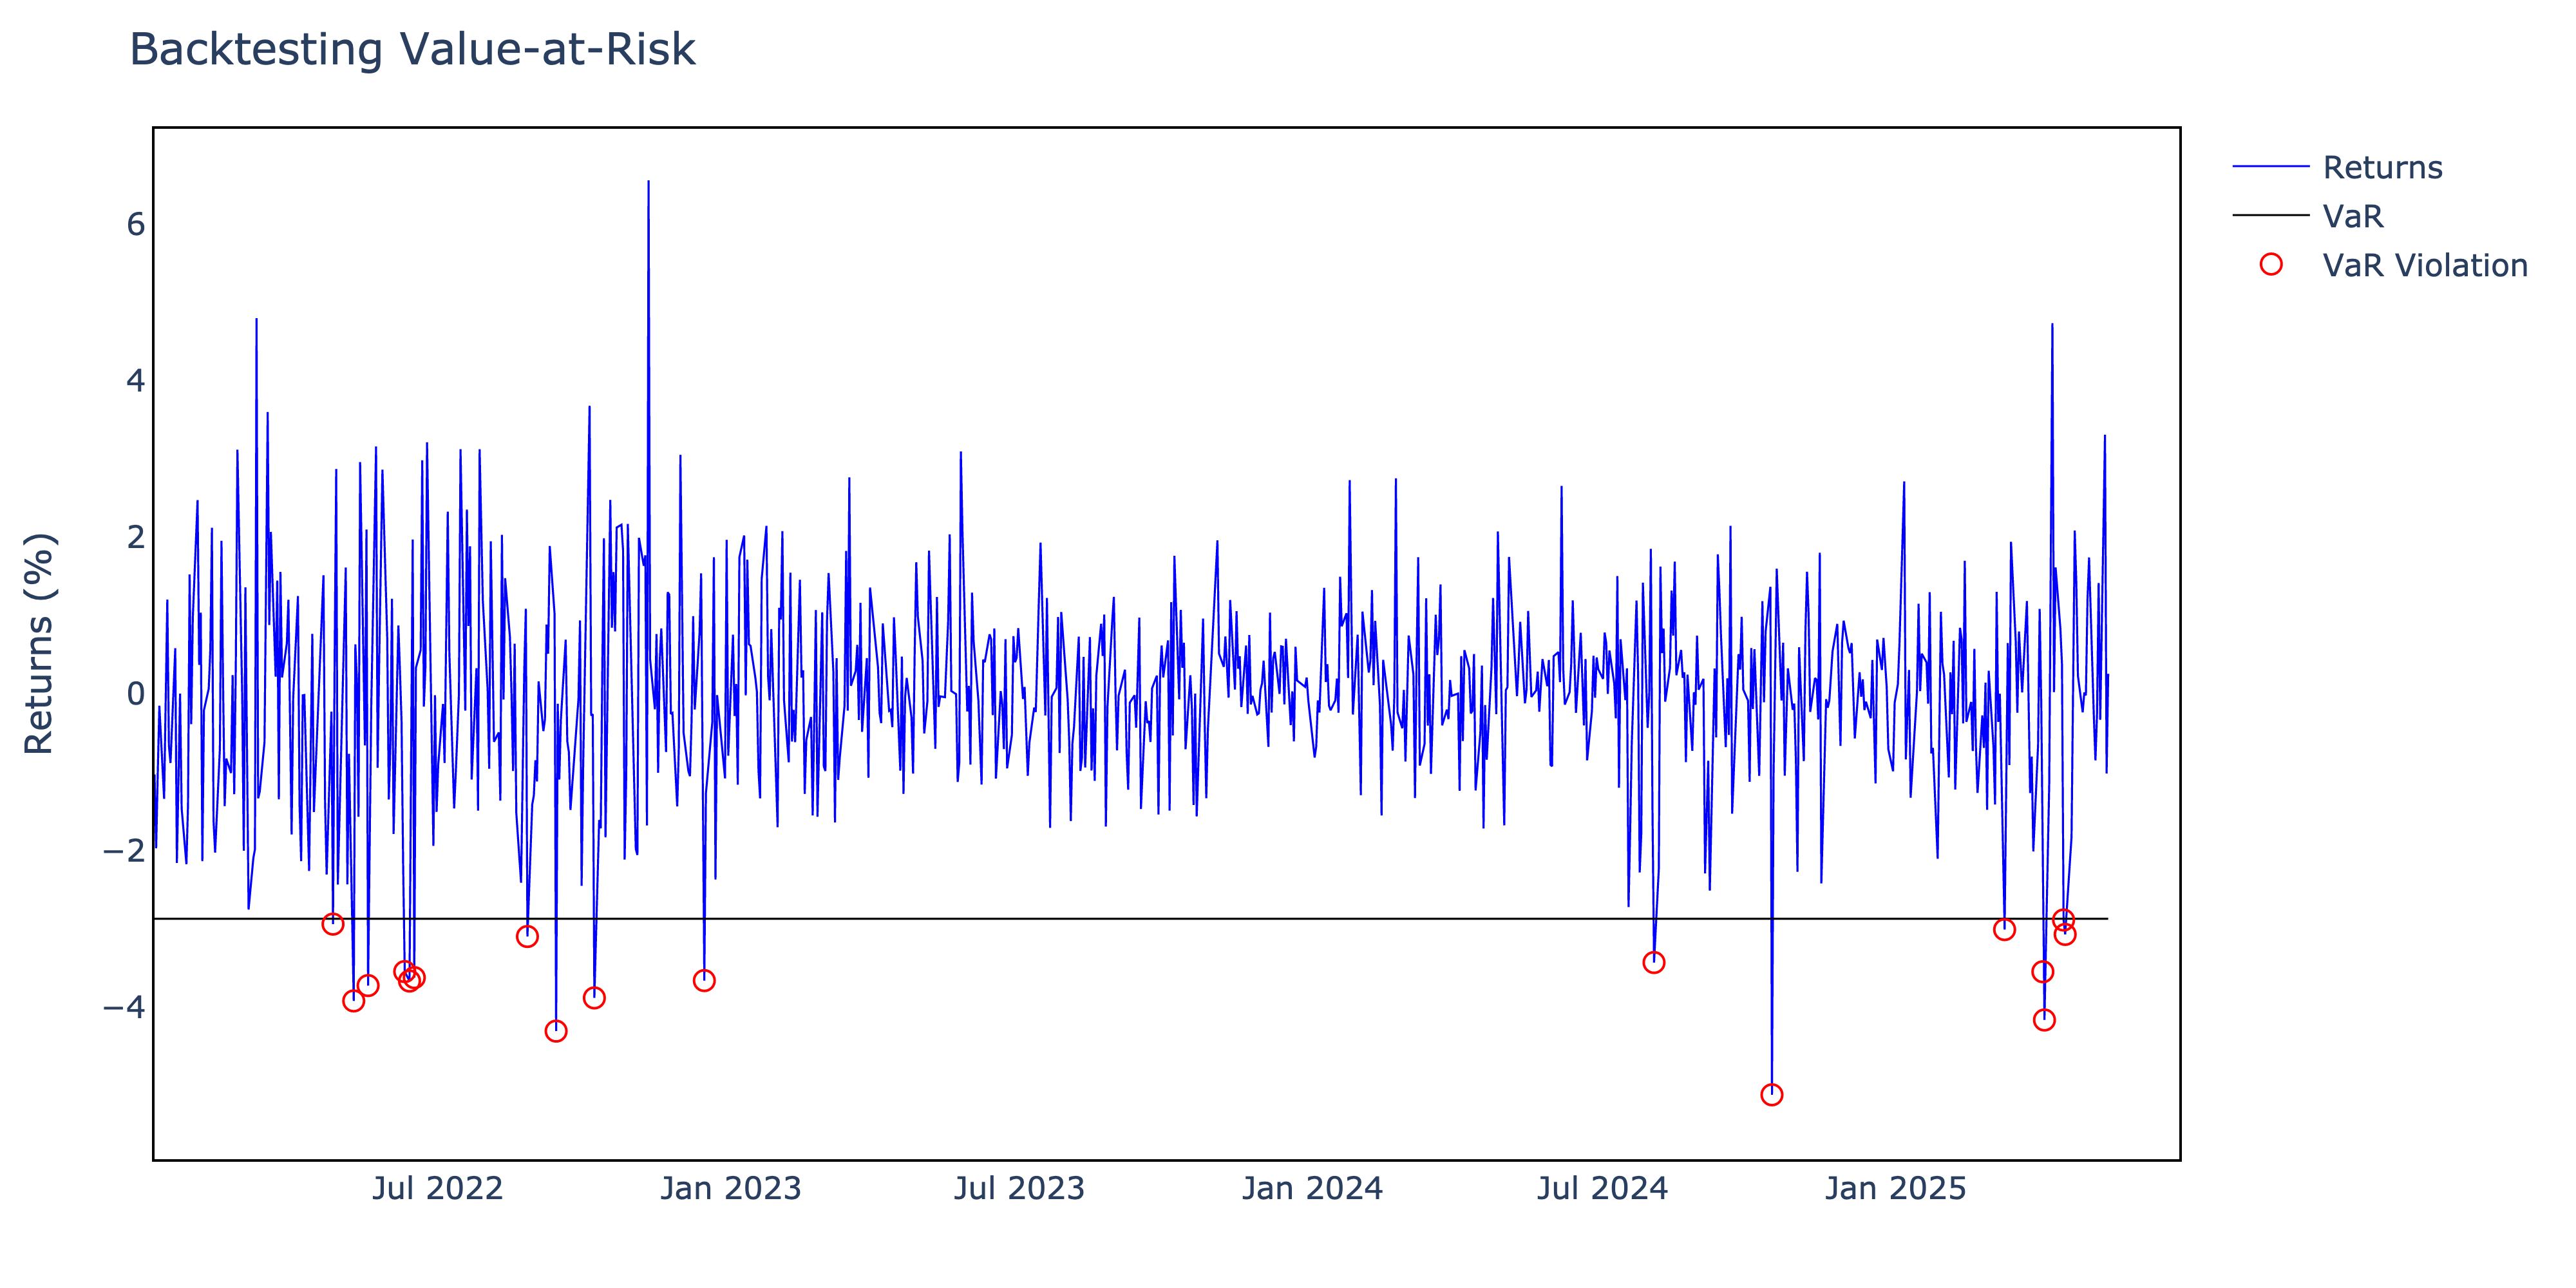

In [8]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [9]:
results_df = fm.factor_models_es(
    result_data= results_df,
    portfolio_volatility=portfolio_volatility,
    confidence_level = 0.99
)

In [10]:
results_df.head()


,Returns,Benchmark,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,
2022-01-04,-0.010264,-0.000630,0.028707,False,767.856276,0.032889,879.705692
2022-01-05,-0.019714,-0.019393,0.028707,False,767.856276,0.032889,879.705692
2022-01-06,-0.010154,-0.000964,0.028707,False,767.856276,0.032889,879.705692
2022-01-07,-0.001504,-0.004050,0.028707,False,767.856276,0.032889,879.705692
2022-01-10,-0.013391,-0.001441,0.028707,False,767.856276,0.032889,879.705692



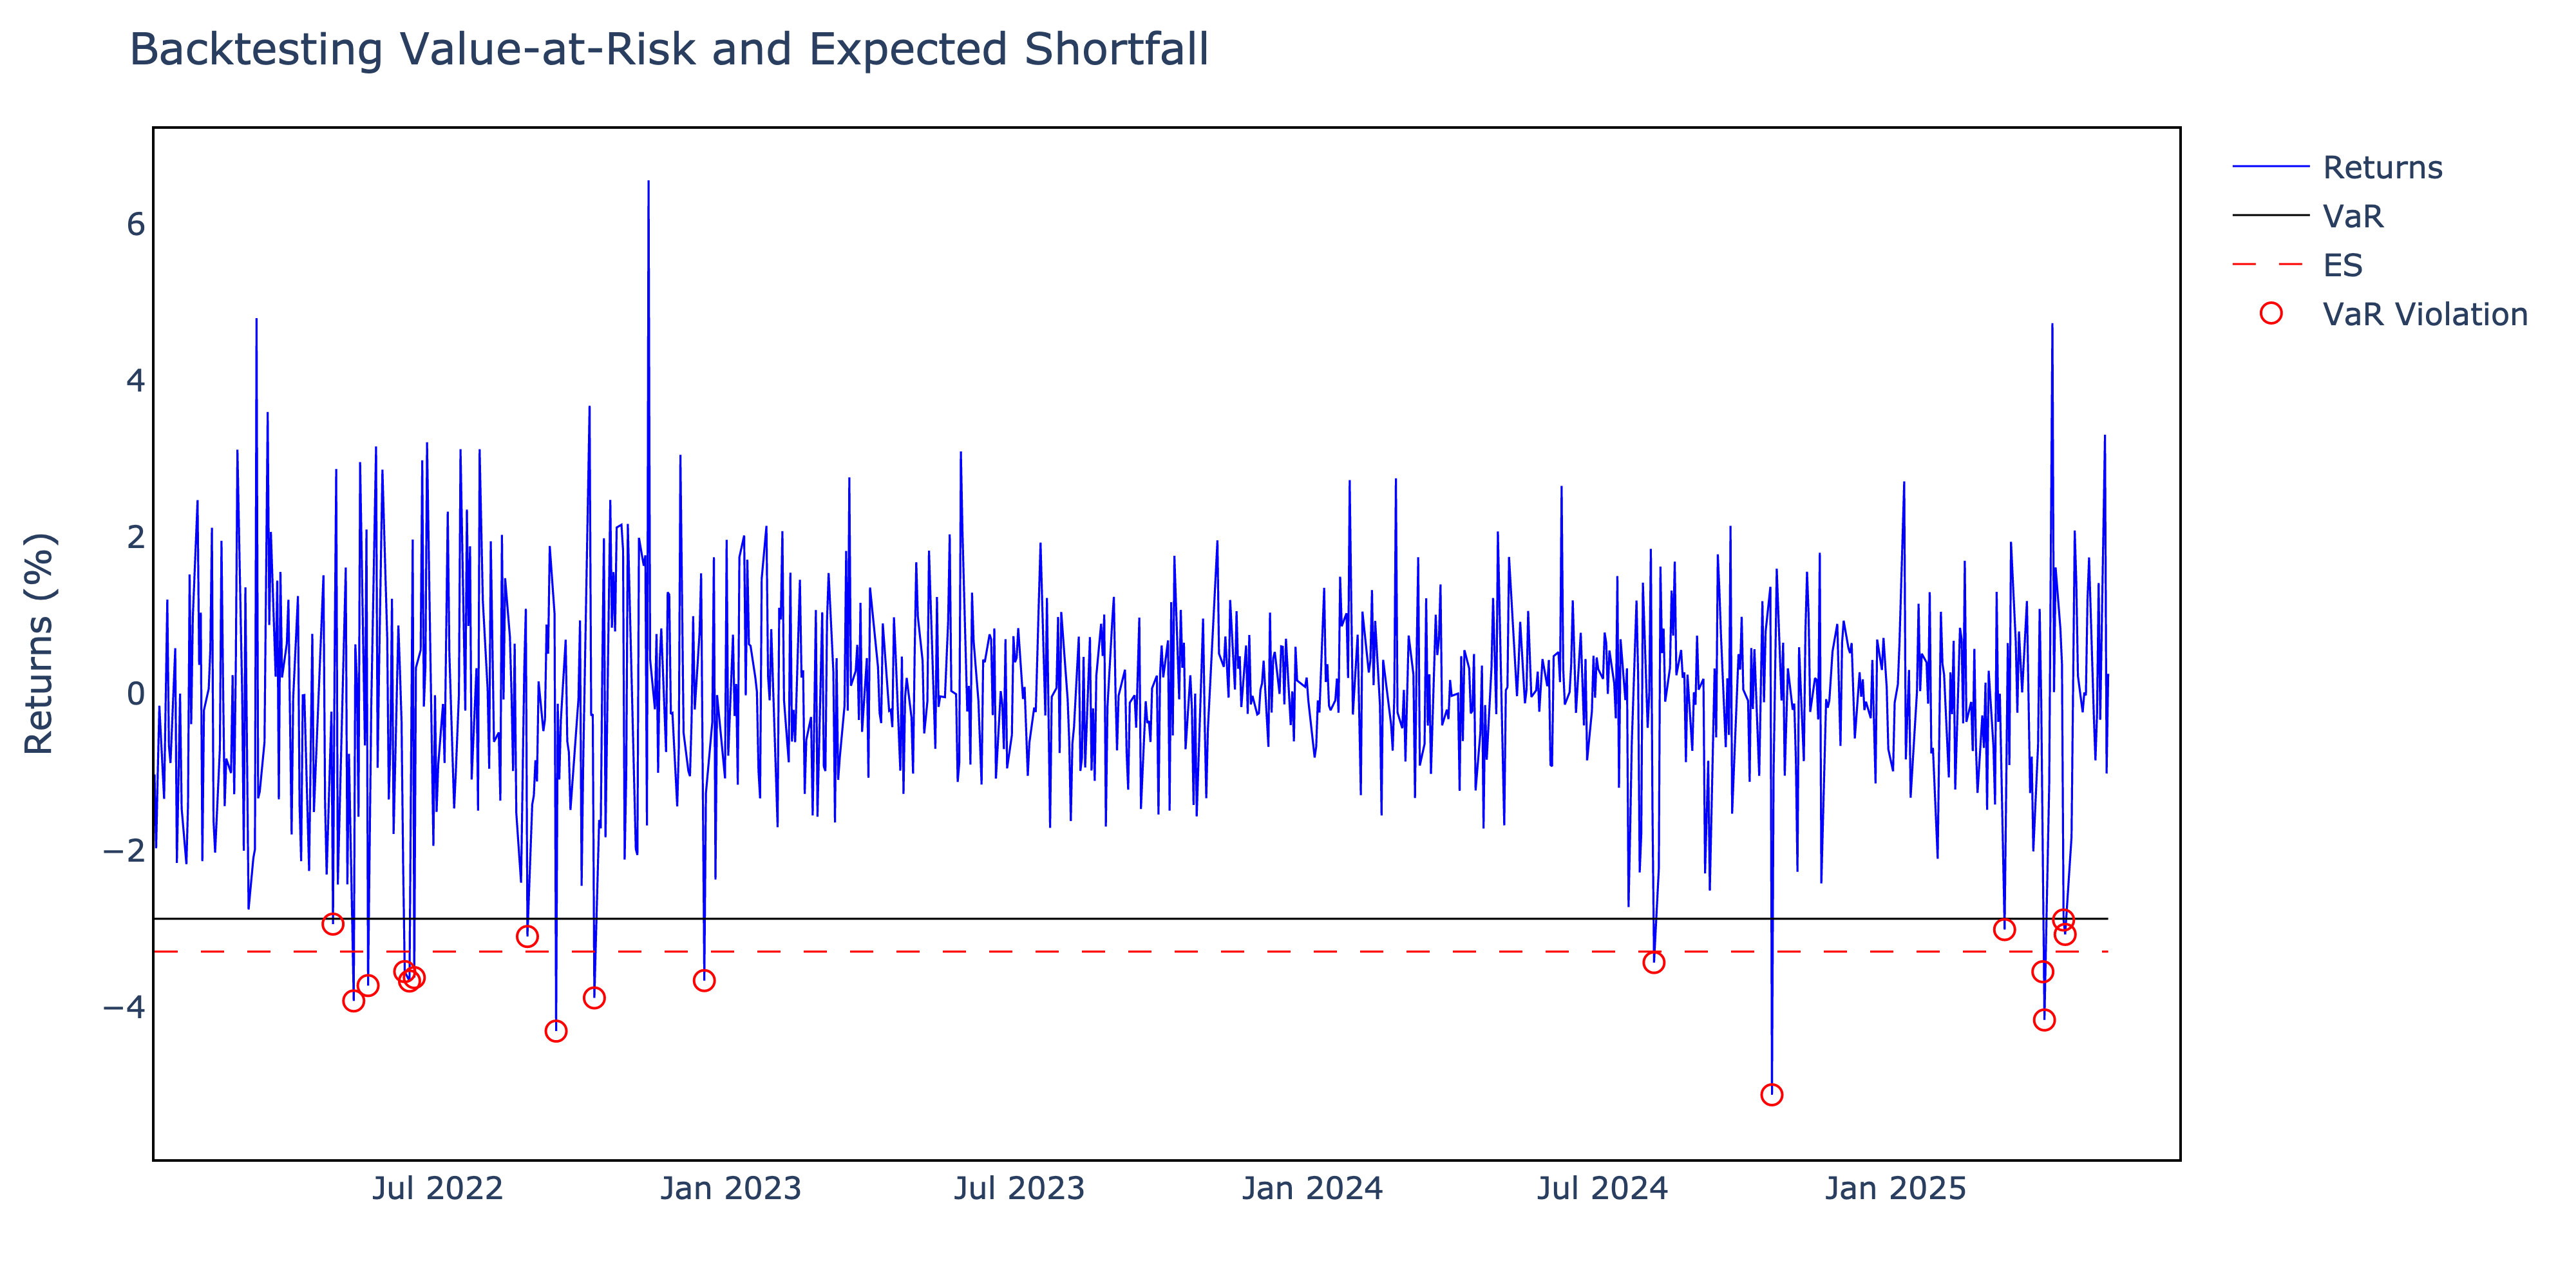

In [11]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

## Fama-French 3-Factor VaR and ES

The Fama–French 3-factor model extends the CAPM by modeling asset returns using three sources of systematic risk:

- **Mkt_RF**: excess return of the market over the risk-free rate  
- **SMB** ("Small Minus Big"): return of small-cap stocks minus large-cap  
- **HML** ("High Minus Low"): return of high book-to-market stocks minus low  

Each asset’s excess return is regressed on these three factors to estimate its **exposures (betas)**. The model assumes:

$$
R_i - R_f = \alpha_i + \beta_{i1} \cdot \text{Mkt}_{RF} + \beta_{i2} \cdot \text{SMB} + \beta_{i3} \cdot \text{HML} + \varepsilon_i
$$

The estimated covariance matrix of asset returns is reconstructed as:

$$
\Sigma = B \cdot \Sigma_f \cdot B^T + D
$$

Where:
- $B$: matrix of asset betas  
- $\Sigma_f$: covariance matrix of factor returns  
- $D$: diagonal matrix of idiosyncratic variances  

The next code block performs the following steps:

1. Downloads the FF3 daily factor data from Ken French's database.
2. Computes **excess returns** for each asset over the risk-free rate.
3. Regresses each asset’s excess return on the three factors to obtain:
   - **Beta coefficients** (exposures to Mkt_RF, SMB, HML)
   - **Idiosyncratic variance** (residual risk)
4. Builds the **full covariance matrix** of asset returns using the factor structure.
5. Computes **portfolio volatility** using the covariance matrix and current weights.
6. Calculates:
   - **Value-at-Risk (VaR)** at the given confidence level
   - **Conditional VaR (CVaR)**, i.e. expected loss beyond the VaR threshold

The printed outputs show all key components estimated during this process.

In [12]:
# # Download FF3 daily factors and restrict to portfolio date range
# ff_factors = fm.load_ff3_factors(start=returns.index[0], end=returns.index[-1])

# # Check first few rows
# ff_factors.head()

In [13]:
new_df, portfolio_volatility_new = fm.fama_french_var(
    returns=returns, 
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)

new_df.head()

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary
Date,,,,,,,
2022-01-04,-0.010264,-0.0029,-0.0083,0.0364,0.027649,False,739.547533
2022-01-05,-0.019714,-0.0228,-0.0145,0.0259,0.027649,False,739.547533
2022-01-06,-0.010154,0.0000,0.0020,0.0175,0.027649,False,739.547533
2022-01-07,-0.001504,-0.0048,-0.0132,0.0202,0.027649,False,739.547533
2022-01-10,-0.013391,-0.0015,-0.0023,-0.0028,0.027649,False,739.547533


In [14]:
results_df_new = fm.factor_models_es(
    result_data= new_df,
    portfolio_volatility=portfolio_volatility_new,
    confidence_level = 0.99
)

results_df_new.head()   

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,,,
2022-01-04,-0.010264,-0.0029,-0.0083,0.0364,0.027649,False,739.547533,0.031676,847.273369
2022-01-05,-0.019714,-0.0228,-0.0145,0.0259,0.027649,False,739.547533,0.031676,847.273369
2022-01-06,-0.010154,0.0000,0.0020,0.0175,0.027649,False,739.547533,0.031676,847.273369
2022-01-07,-0.001504,-0.0048,-0.0132,0.0202,0.027649,False,739.547533,0.031676,847.273369
2022-01-10,-0.013391,-0.0015,-0.0023,-0.0028,0.027649,False,739.547533,0.031676,847.273369



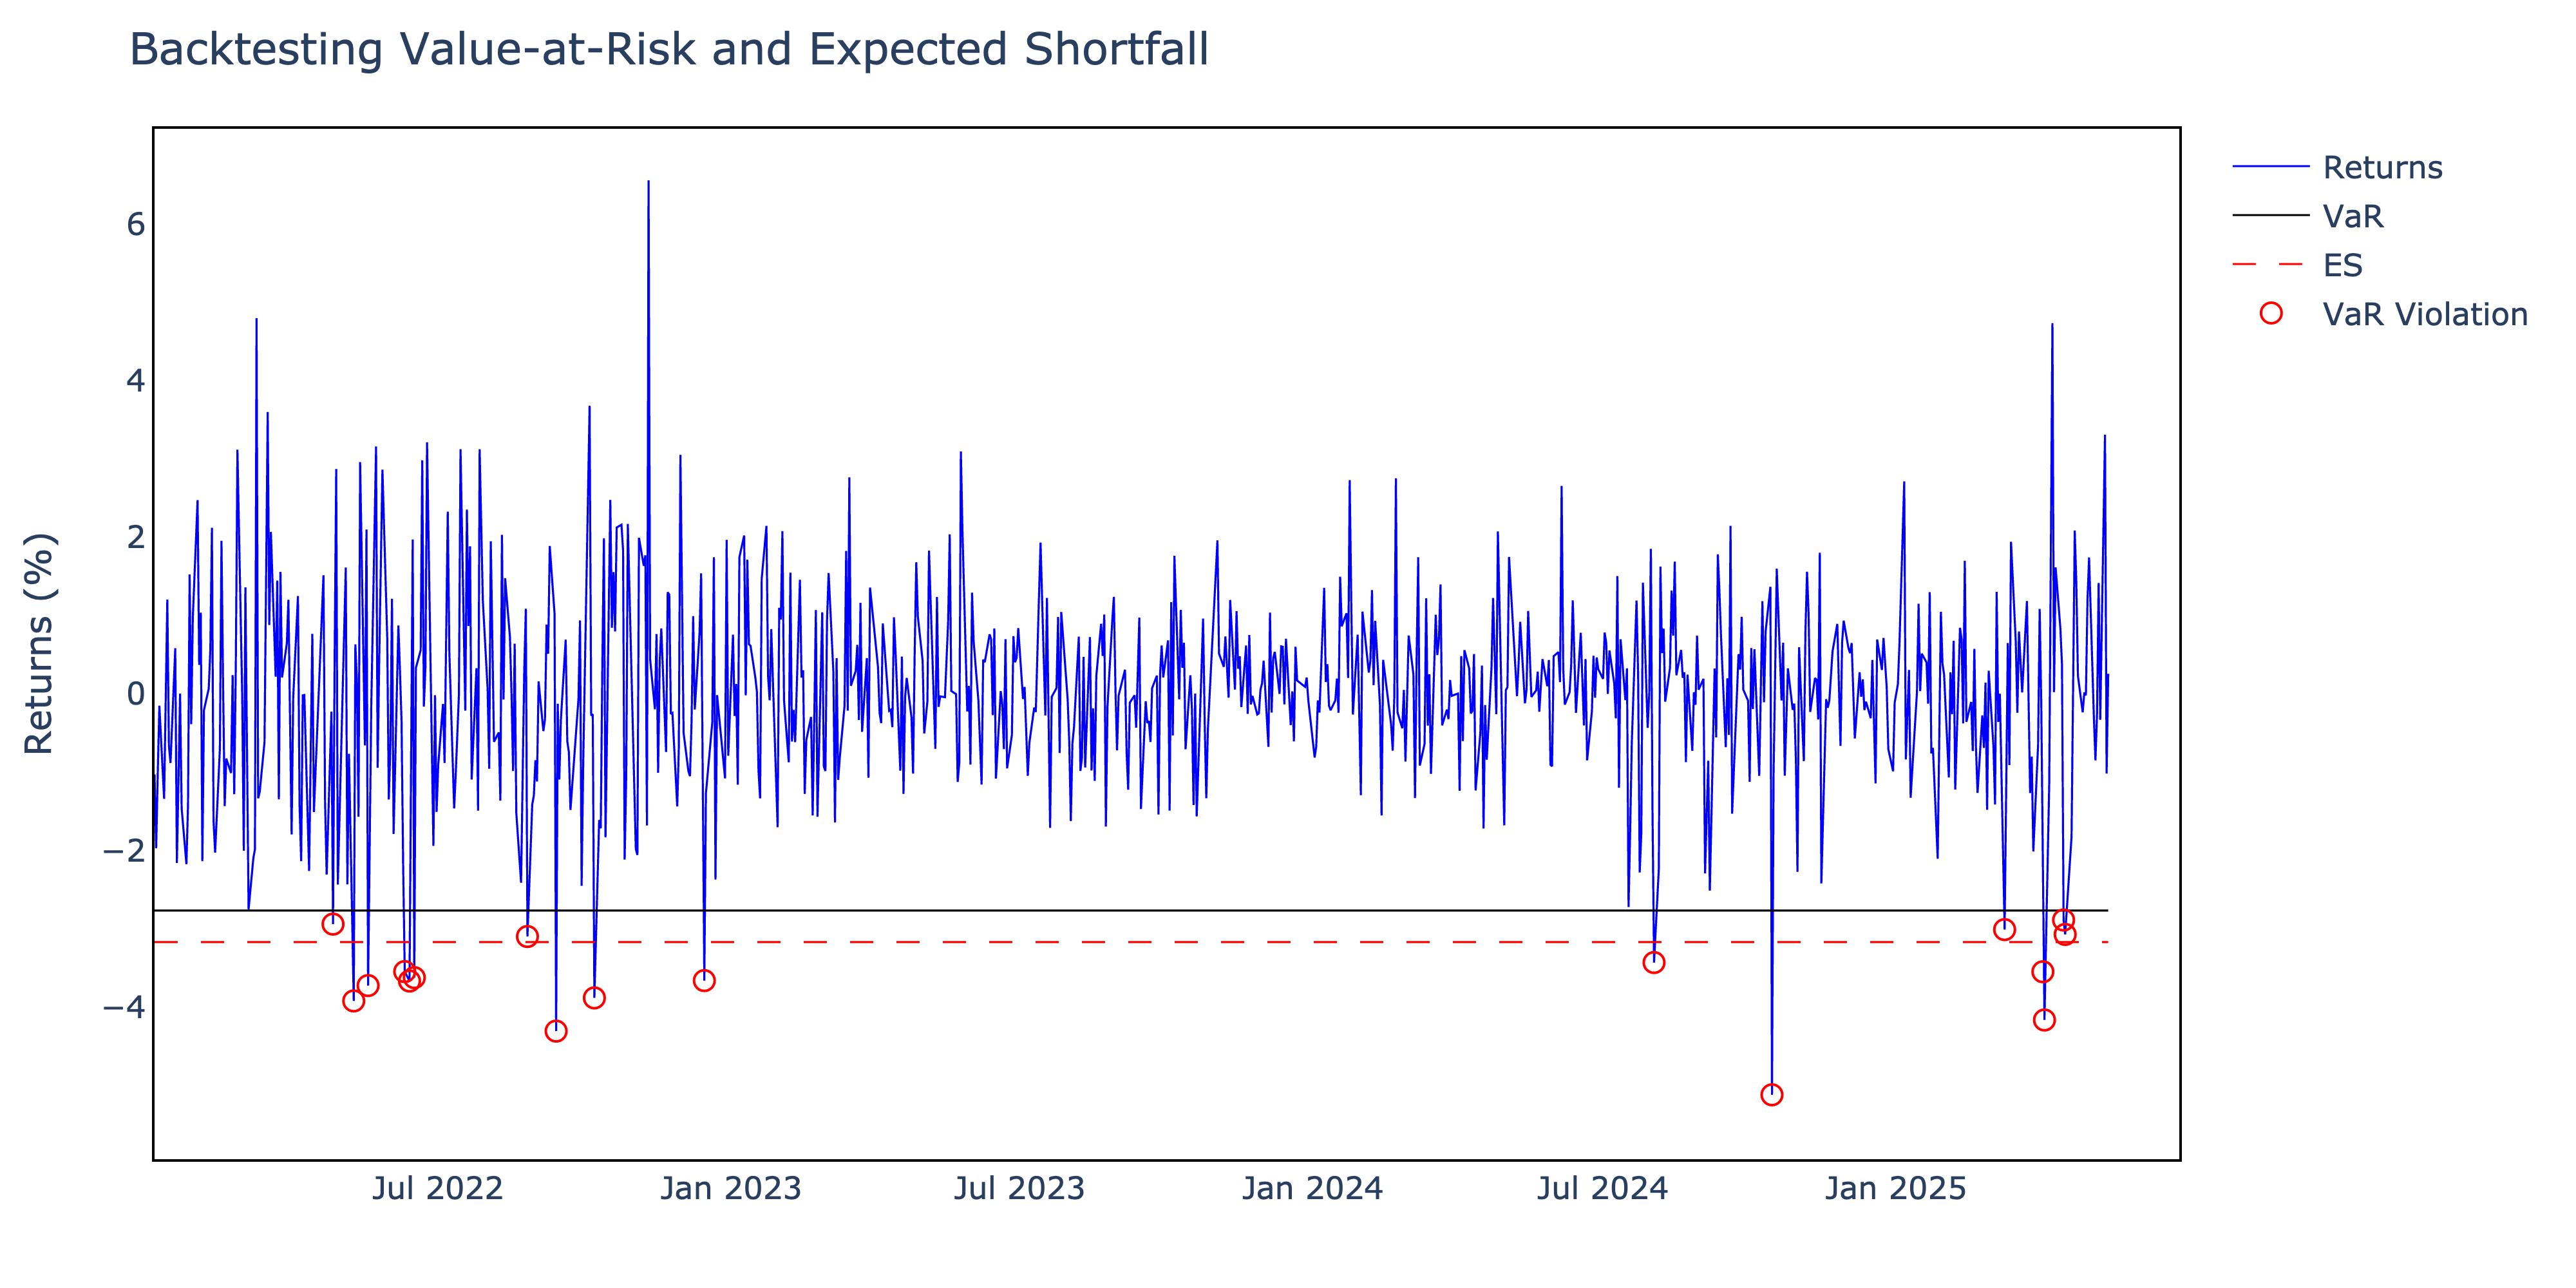

In [15]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df_new, interactive=False)